In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [7]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)
conn = engine.connect()

# Exploratory Precipitation Analysis

In [12]:
#create table of Measurement data to see header labels
data = pd.read_sql("SELECT* FROM Measurement", conn)
data.head(5)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    order_by(Measurement.date).\
    filter(Measurement.date >= dt.date(2016,8,23)).all()   

# Save the query results as a Pandas DataFrame. 
# Explicitly set the column names
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"]).set_index("Date")
precipitation_df = precipitation_df.sort_values("Date")
precipitation_df.head(5)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


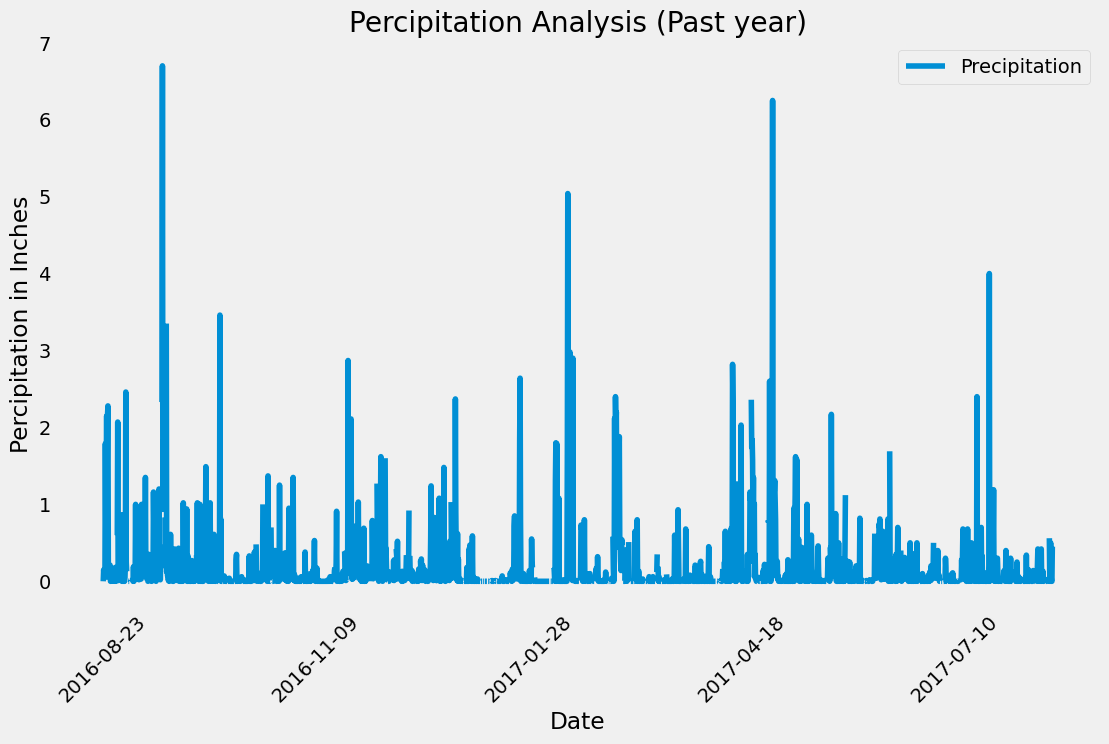

In [96]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title="Percipitation Analysis (Past year)", figsize=(12,7)).grid()
plt.xlabel("Date")
plt.ylabel("Percipitation in Inches")
plt.xticks(rotation=45)
plt.show()

In [97]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()


,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [98]:
#create table of Station data to see the data
data = pd.read_sql("SELECT* FROM Station", conn)
data.head(5)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.4234,-157.8015,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.5213,-157.8374,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.3934,-157.9751,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.4992,-158.0111,306.6


In [99]:
# Design a query to calculate the total number of stations in the dataset
stations_count = session.query(Station.station).count()
stations_count

9

In [100]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [101]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.
most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

most_active_station

[(54.0, 85.0, 71.66378066378067)]

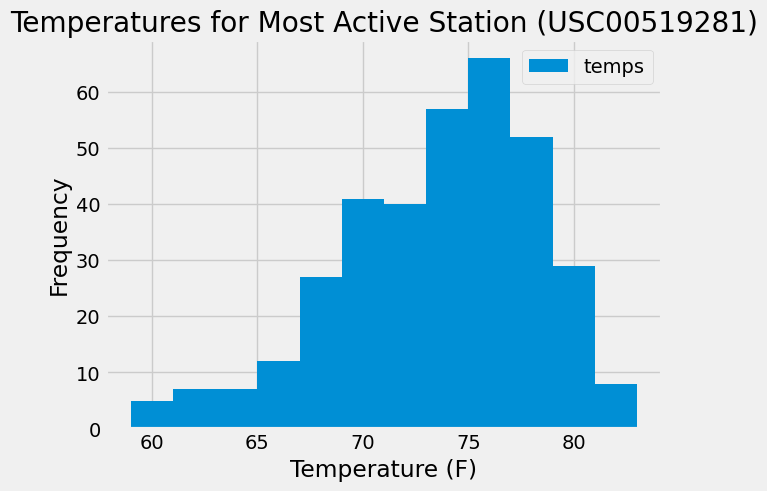

In [102]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_station_temp = session.query(Measurement.tobs).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date > dt.date(2016,8,23)).all()

df = pd.DataFrame(most_active_station_temp, columns=['temps'])
df.plot.hist(bins=12)
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title("Temperatures for Most Active Station (USC00519281)")
plt.show()

# Close Session

In [103]:
# Close Session
session.close()